# Analyse des parkings de Montpellier
Ce notebook contient le traitement de données effectué dans le cadre de l'analyse de l'usage des parkings de Montpellier.
## Collecte des données
La collecte des données est effectuées toutes les 5 minutes depuis les datasets en Open Data suivants:
- X
- Y

Chaque échantillon est sauvegardée dans son propre dossier timestampé (format ISO 8601/RFC3339, avec une substitution du caractère ':' par '_'), eux mêmes situés selon leur type dans le dossier ``data/{bicycle, car}Parks``.

Pour plus de détails sur la collecte, voir le [code source du collecteur](../main.py)
## Importation
Le script [importerPython](./importerPython.py) est chargé de la déserialization des données récollectées:

In [ ]:
import importerPython
import os

# Les scripts doivent tourner depuis la racine du projet.
# Le changement de CWD persistant après l'exécution du snippet, il peut être nécecssaire de décomenter cette ligne, d'exécuter ce snippet, puis de le recommenter.
# Cette situation est hélas assez peu idéale.
#os.chdir("../../") 
#print(os.listdir("."))

rawCarData = importerPython.car()
rawBicycleData = importerPython.bicycle()


print(f"Total car parkings datapoints: {len(carData)}")
print(f"Total bicycle parkings datapoints: {len(bicycleData)}")

# On stocke ces variables dans le contexte global de notre notebook afin de ne pas avoir à retraiter les données à chaque étape.
%store rawCarData
%store rawBicycleData 

## Filtrage
Certaines données récollectées possèdent un certain nombres d'abérations ou de propriétés les rendant inexploitables:

### Voitures
- Les parkings fermés ne sont pas représentatifs des patterns d'occupations des parkings ouverts et doivent donc être exclus ; 
- Certains parkings ne sont pas marqués comme fermés malgré l'ancienneté des données remontées (Comédie par exemple) ;
- Pour des raisons diverses (réseau, renommage), certains échantillons sont vides ou invalides. Ils doivent donc également être exclus.

On applique donc un certains nombre de filtres:
- Si le statut n'est pas "OPEN", on exclue l'échatillon du dataset
- Si la date de dernière actualisation remontée par l'API diverge de plus de 12 heures de la date de collecte, on exclue l'échantillion du dataset.
- Enfin, si l'échantillon n'est pas un fichier XML valide, on l'exclue également du dataset.

### Vélos
- La capacité totale de certains parkings est égale à 0, ce qui est problématique lors du calcul de la saturation (cas du parking "Bois vert").

Enfin, tous les samples sont triés par ordre chronologique.

Ces filtres sont pour certains appliqués directement à la déserialization, les autres le sont dans le snippet suivant:

In [ ]:
# On charge le dataset
%store -r rawCarData
%store -r rawBicycleData

carData = rawCarData
bicycleData = rawBicycleData

initialCarSamplesQty = len(carData)
# Filtre de statut
validStatus = ["OPEN", "FULL"]
for park in carData:
    if park.status.upper() not in validStatus:
        print(f"Invalid status for {park.name}: {park.status}")
        rawCarData.remove(park)

print(f"Filtered car data. Valid samples: {len(carData)} out of {initialCarSamplesQty}")

initialBicycleSamplesQty = len(bicycleData)

for park in bicycleData:
    if park.getTotal() == 0:
        bicycleData.remove(park)
        print(f"Removed {park.name}, as its capacity was 0.")

print(f"Filtered car data. Valid samples: {len(bicycleData)} out of {initialBicycleSamplesQty}")


# On trie ensuite par ordre chronologique
carData.sort(key=lambda data: data.date)
# Même traitement pour les vélos:
bicycleData.sort(key=lambda data: data.date)

# On stocke la version filtrée.
%store carData
%store bicycleData

## Visualization

### Saturation moyenne

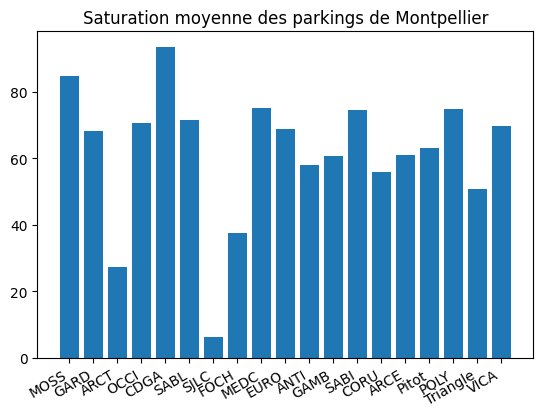

In [127]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta

# On charge les datasets
%store -r carData
%store -r bicycleData 

# On filtre les parkings
#cutOffDate = int((datetime.today() - timedelta(days=70)).timestamp())
#parkings = [p for p in carData if (p.getDate() > cutOffDate)]

# Format souhaité : {"nom du parking": [ParkingData]}
parkingsByName = {}
for parking in carData:
    previousEntries = parkingsByName.get(parking.name, [])
    previousEntries.append(parking)
    parkingsByName.update({parking.name: previousEntries})

parkingByAvgSaturation = {}

for name, datapoints in parkingsByName.items():
    mean_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
    mean = sum(mean_array)/len(mean_array)*100 # On scale directement en pourcents.
    parkingByAvgSaturation.update({name: mean})

fig, ax = plt.subplots()
#plt.bar(x, y1)
barContainer = plt.bar(parkingByAvgSaturation.keys(), parkingByAvgSaturation.values())
plt.title("Saturation moyenne des parkings de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()

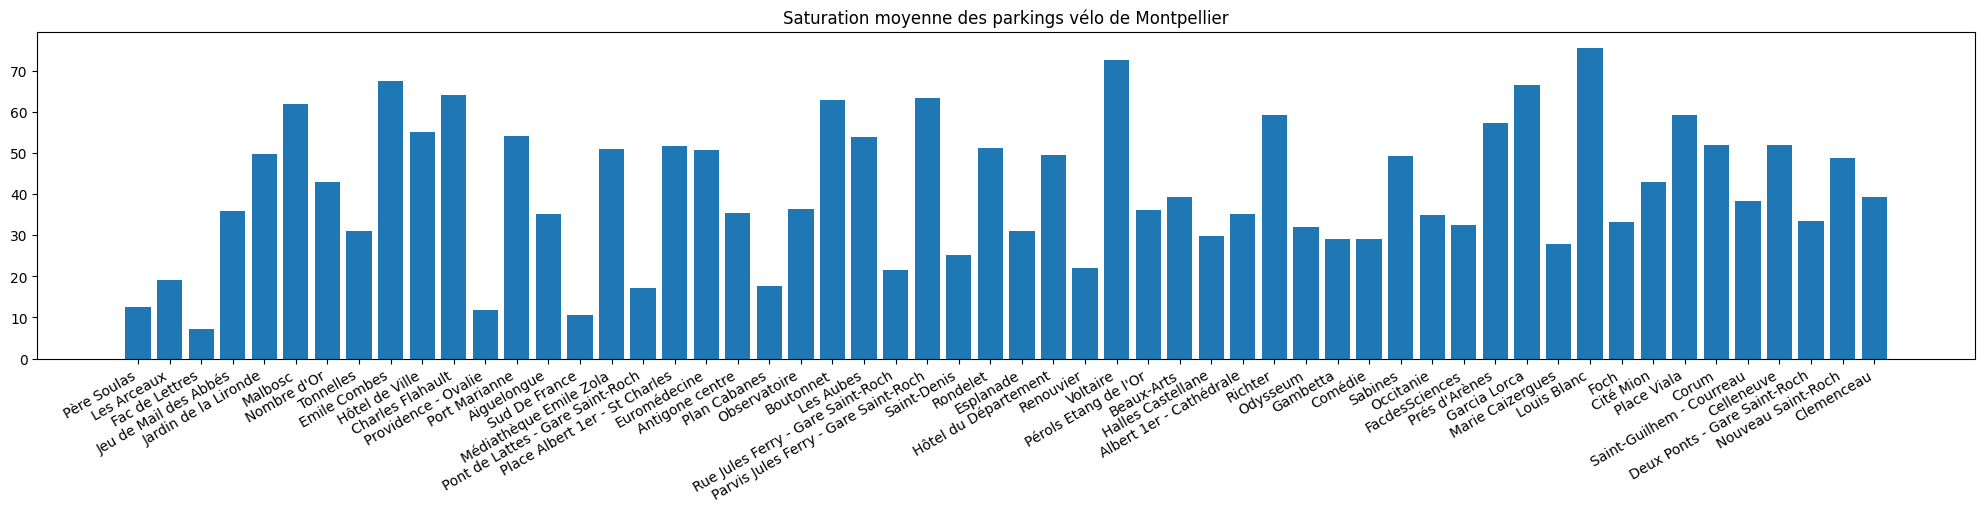

In [128]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta

# On charge les datasets
%store -r carData
%store -r bicycleData 
parkingsByName = {}
for parking in bicycleData:
    previousEntries = parkingsByName.get(parking.name, [])
    previousEntries.append(parking)
    parkingsByName.update({parking.name: previousEntries})

parkingByAvgSaturation = {}

for name, bicycleParkDataPoints in parkingsByName.items():
    bicycleSaturation = [datapoint.getFree()/datapoint.getTotal() for datapoint in bicycleParkDataPoints if datapoint.getTotal() != 0]  
    mean = sum(bicycleSaturation)/len(bicycleSaturation)*100 # On scale directement en pourcents.
    parkingByAvgSaturation.update({name: mean})

fig, ax = plt.subplots()
#plt.plot(x, y1)
fig.set_figwidth(25)
BarContainer = plt.bar(parkingByAvgSaturation.keys(), parkingByAvgSaturation.values())
plt.title("Saturation moyenne des parkings vélo de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()

### Interprétation parkings voiture.

### Corrélation avec les heures de la journée (sur un jour de la semaine): 
On observe sur un jour de la semaine que la saturation moyenne des parkings voitures sont plus importantes le matin et le soir. On en déduit que c'est à ce moment que les trajets en voiture sont le plus solicités. Cela s'explique par le fait que les automobilistes doivent partir travailler en voiture le matin et rentrer le soir, comme le montre ce graphique où l'on observe une légère baisse du taux d'occupation des parkings en horraire creuse, soi l'après_midi, contrairement aux heures de pointes soit le matin et le soir.


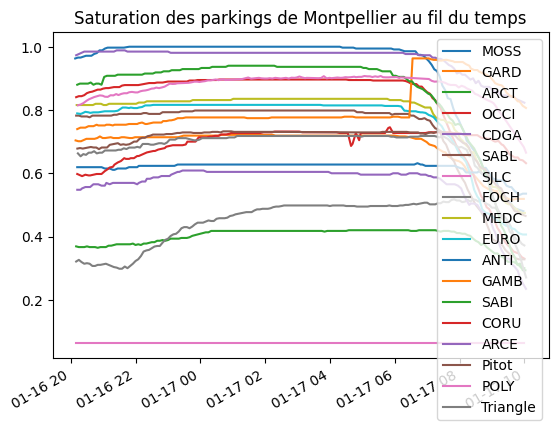

In [17]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData
%store -r bicycleData 

fig, ax = plt.subplots()
plt.title("Saturation des parkings de Montpellier au fil du temps")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints  in parkingsByName(carData).items():
    mean_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
    plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_array, label=name)

plt.legend()
plt.show()

### Corrélation avec les heures de la journée (week-end): 
De plus, on observe que sur un jour du week-end, l'inverse se produit avec une hausse de la saturation moyenne des parkings voitures l'après-midi, en plus du soir, contrairement au matin. Cela s'explique par le fait que les automobilistes se reposent le matin suite au travail de la semaine efffectué. La saturation des parkings l'après-midi s'explique donc par le fait qu'une fois reposés, les automobilistes utilisent le reste de la journée pour sortir décomprésser, d'où l'usage de la voiture à cette période.

In [117]:
# Graphique de la saturations des parkings le lundi samedi 21 janvier sur toute la journée.

### Corrélation avec les jours de la semaine: 
D'autres corélations peuvent être obsevées à plus grande echelle, soit à l'echelle de la semaine. En effet, comme le montre le graphe ci-dessous, on peut voir que la saturation des parkings de Montpellier est plus importante en semaine qu'en week-end. C'est un phénomène récurent qui s'explique par le fait que les automobilistes ayant un travail se voient aller travailler (obligatoirement) pendant la semaine, contrairement au week-end où rien ne les force à utiliser leur voiture, d'où l'écart excessif entre la saturation des parkings en semaine et le week-end.

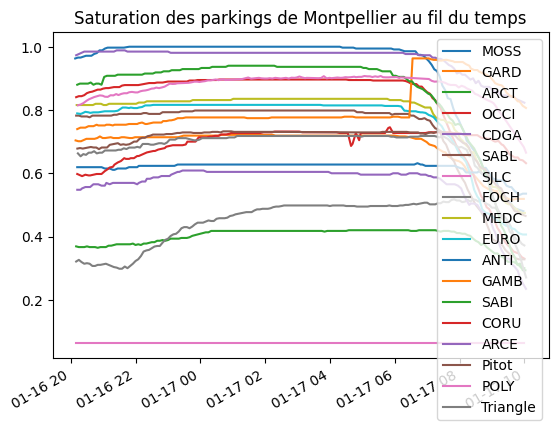

In [2]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData
%store -r bicycleData 

fig, ax = plt.subplots()
plt.title("Saturation des parkings de Montpellier au fil du temps")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints  in parkingsByName(carData).items():
    mean_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
    plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_array, label=name)

plt.legend()
plt.show()

### Corrélation avec les événements locaux:
Des évenements extérieurs peuvent amener à influencer les caractéristiques d'un parking, comme les évenements à echelle locale qui comme le montre le graphique représenté ci-dessous, font croitre l'utilisation du parking Fosh étant donné qu'il est proche du théâtre Jérôme Savary où se déroule vers 21h, une pièce de théâtre accrocheuse qui s'intitule "Nazi et le Barbier". En effet, les parkings ne sont pas censés être occupés à cette heure tardive, d'autant plus à cette adresse car il n'y a pas d'évenements ou activités attractives dans les envrirons, hormis le fameux théâtre de Jérôme Savary.

In [20]:
# Graphique de la saturations du parking Foch le vendredi 20 janvier sur toute la journée.

### Corrélation avec les événements exeptionnels:
Il arrive que dans certains cas exeptionnels, l'utilisation des parkings voitures soient modifié, comme lors de la grève nationale du 19 janvier à Montpellier qui explique la baisse de saturations des parkings voitures à cette date.

In [120]:
# Comparaison graphique de la saturations des parkings de Montpellier le jeudi 19 janvier avec le mercredi 18 janvier.

### Corrélations statistiques parkings vélos

### Corrélation avec les politiques de la ville:
Il faut savoir que Montpellier est la 9e ville la plus chère pour se garer. De plus, celle-ci adopte de nombreuses mesures afin de diminuer la place de l’automobile comme avec la diminution du nombre de places de stationnement ou l'augmentation du coût du stationnement. La Métropole veut lutter contre les vols qui augmentent et découragent les cyclistes, qui de plus en plus concerne également les deux-roues. C'est pourquoi on observe une saturation importante des parkings vélo proches du centre-ville comme Louis Blanc qui est un parking vélo très fréquemment utilisé en moyenne car il se situe en plein coeur de la ville.

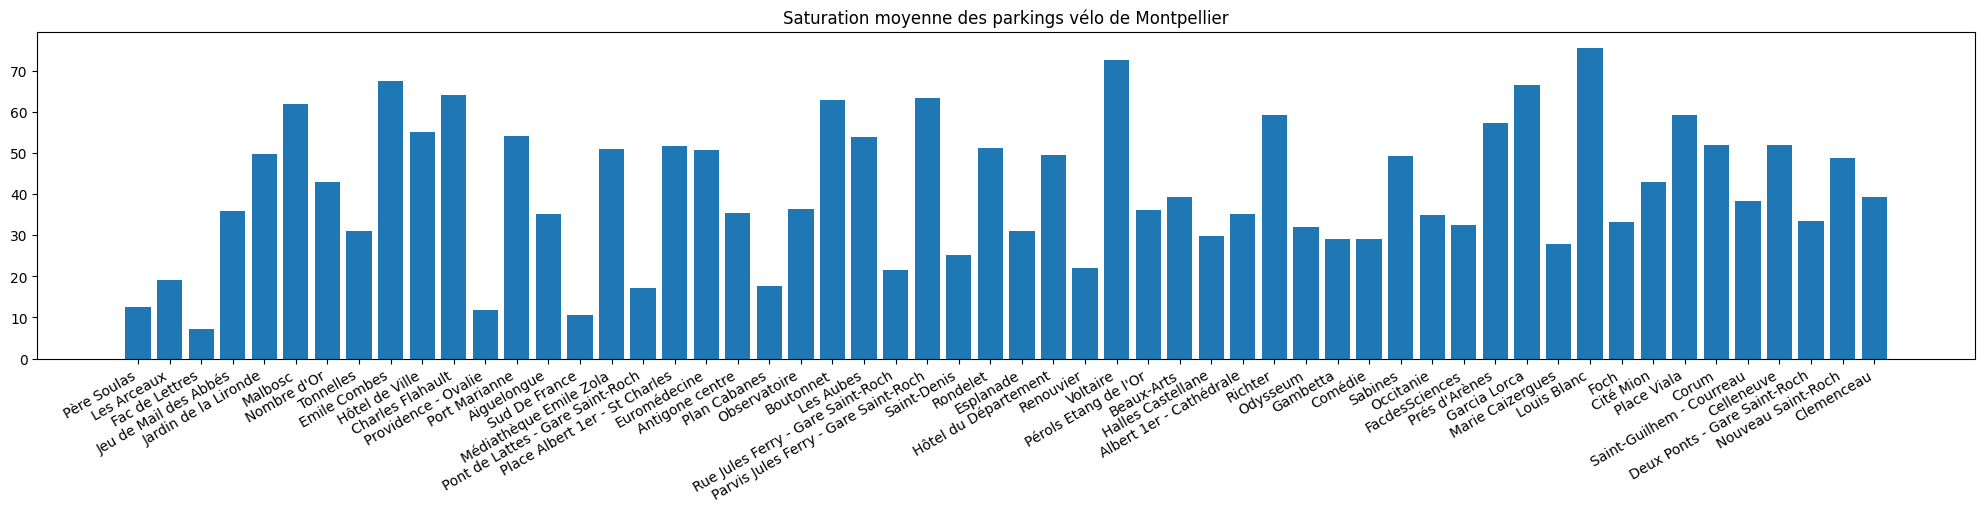

In [121]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta

# On charge les datasets
%store -r carData
%store -r bicycleData 
parkingsByName = {}
for parking in bicycleData:
    previousEntries = parkingsByName.get(parking.name, [])
    previousEntries.append(parking)
    parkingsByName.update({parking.name: previousEntries})

parkingByAvgSaturation = {}

for name, bicycleParkDataPoints in parkingsByName.items():
    bicycleSaturation = [datapoint.getFree()/datapoint.getTotal() for datapoint in bicycleParkDataPoints if datapoint.getTotal() != 0]  
    mean = sum(bicycleSaturation)/len(bicycleSaturation)*100 # On scale directement en pourcents.
    parkingByAvgSaturation.update({name: mean})

fig, ax = plt.subplots()
#plt.plot(x, y1)
fig.set_figwidth(25)
BarContainer = plt.bar(parkingByAvgSaturation.keys(), parkingByAvgSaturation.values())
plt.title("Saturation moyenne des parkings vélo de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()

### Corrélation avec l'accessibilité: 
En effet, un parking à vélos est plus susceptible d'être utilisé s'il est facilement accessible. Par exemple, si il est situé près des stations de transport en commun ou des centres commerciaux comme le parking Louis Blanc de tout-à-l'heure, ou comme le parking Pl. Albert 1er qui est par ailleurs très proche de l'université de la Faculté de Droit et Science politique de Montpellier, ce qui justifie une telle saturation car la majorité des étudiants utilisent les vélos pour se déplacer jusqu'à leur lieu d'étude de part le manque d'argent et le rapprochement de domicile avec celui-ci (les facs prennent obligatoirement les étudiants qui n'ont été acceptés nul part ailleurs en fonction de leur adresse de logement).

### Corrélations avec la sécurité:
Une autre corrélation des données représentées des parkings vélo de Montpellier concerne la sécurité de ces derniers. En effet, si les parkings à vélos sont sécurisés et bien éclairés, ils sont plus susceptibles d'être utilisés. C'est le cas du parking vélo Place Albert 1er - St Charles qui est l'un des premiers parking de Montpellier à favoriser de box sécurisés, qui ont pour but de lutter contre les vols qui augmentent et découragent les cyclistes. On peut voir cette corrélation avec la représentation graphique de l'occupation de celui-ci avec l'occupation du parking Antigone centre En effet, même si les 2 parkings sont proches l'un de l'autre, Parking Albert 1er - St Charles est bien plus occupé que le parking Antigone centre de part sa sécurité qui reflète son utilisation fréquente.

### Corrélation de emplacement:
Certains parkings se voient être utilisés fréquement grâce à leur emplacement. En effet, la présence de restaurant ou de magasins aux alentours peut faire varier considérablement l'utilisation de ces derniers, c'est le cas des parkings vélos proches du centre-ville comme Parking Saint Roche qui bénificie de ces avantages. Par ailleurs, certains emplacements expliquent également une saturation basse d'un parking vélo. On peut citer pour exemple le parking vélo de Renouvier qui, comme représenté graphiquement ci-dessus par le graphique de la saturation moyenne des parkings vélo de Montpellier, n'a pas d'utilisation très élevée car il se situe juste à coté d'une boutique de vélo (UNI RE-CYCLE). Cela s'explique aisément car venir si près d'un magasin de vente/location de vélo signifie que l'on en possède pas encore. Qui plus est, la boutique dispose d'un emplacement où ranger son vélo, l'utilisation faible du parking vélo Renouvier est donc justifié.

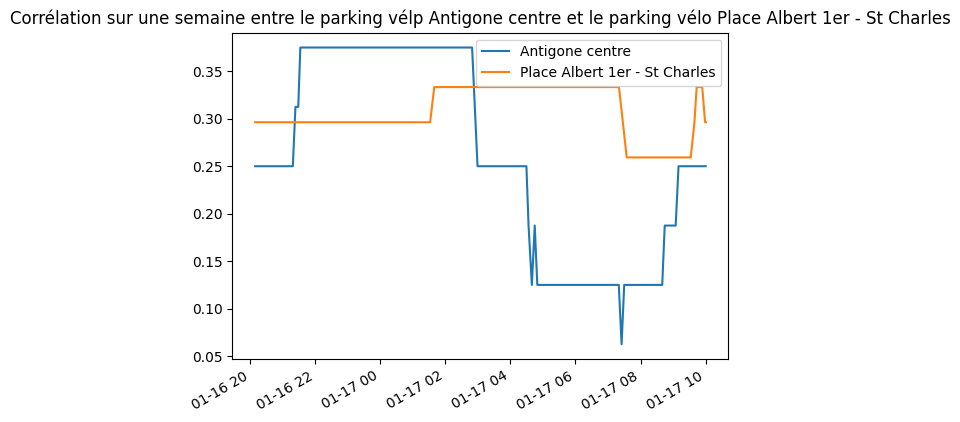

In [16]:
#NB: les commentaires de ce code s'appliquent également pour les prochains, sauf si commentaires ajoutés.
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData #données des parkings voiture 
%store -r bicycleData #données des parkings vélos

parkingbicycle1="Antigone centre" #1er parking vélo
parkingbicycle2="Place Albert 1er - St Charles" #2ème parking vélo

fig, ax = plt.subplots()
plt.title("Corrélation sur une semaine entre le parking vélp "+parkingbicycle1+" et le parking vélo "+ parkingbicycle2)
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints in parkingsByName(bicycleData).items(): #on vient chercher les noms (name) et objets (datapoints) des parkings vélos 
    if name == parkingbicycle1: 
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] #création d'une liste que l'on utilisera pour faire la moyenne de l'occupation d'un parking vélo rentré antérieurement (parkingbicycle1).
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name) #affichage graphique des dates correspondantes aux données des parkings vélo receuillies (en abscisse), de l'occupation moyenne de ces derniers (en ordonnées), et du nom du 1er parkings vélos que l'on à décidé d'observer en légende)
for name, datapoints in parkingsByName(bicycleData).items(): 
    if name == parkingbicycle2: 
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] #création de la liste du deuxième parking vélo (parkingbicycle2)
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name) #même affichage avec le nom du 2ème parkings vélos que l'on à décidé d'observer en légende.
plt.legend()
plt.show()

### Corrélations avec la capacité: 
Comme pour les parkings voiture, un parking à vélos de capacité plus faible sera plus souvent rempli qu'un autre de plus grande capacité. L'exemple parfait se reflète à travers le pôle service vélo à la gare Saint Roch (360 places disponibles) qui a une saturation moyenne plus basse qu'un parking vélo à plus faible capacité comme Renouvier (200 places disponibles) ainsi qu'une position géographique moins attractive (plus loin du centre-ville)

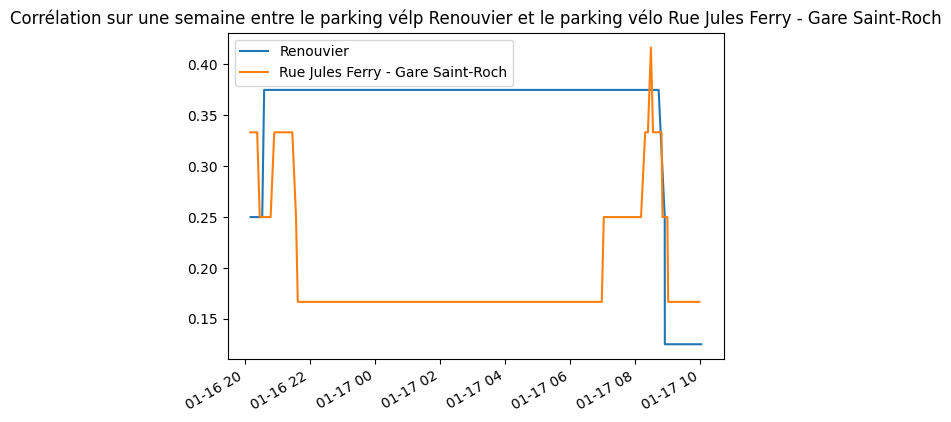

In [13]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData
%store -r bicycleData 

parkingbicycle1="Renouvier"
parkingbicycle2="Rue Jules Ferry - Gare Saint-Roch"

fig, ax = plt.subplots()
plt.title("Corrélation sur une semaine entre le parking vélo "+parkingbicycle1+" et le parking vélo "+ parkingbicycle2)
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle1:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle2:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
plt.legend()
plt.show()

### Corrélations avec le temps:
Si les conditions météorologiques sont défavorables, il est possible de voir une baisse de l'utilisation des parkings vélos. En effet, ce jeudi 19 janvier, Montpellier fut mis en alerte orange suite à l'arrivée de neige-verglas au sud de la France, c'est pourquoi on peut voir une légère baisse de la saturation moyenne des parkings à vélos entre le le mercredi 18 janvier et le jeudi 19 janvier.

In [123]:
# Comparaison graphique de la saturations des parkings vélo de Montpellier le jeudi 19 janvier avec le mercredi 18 janvier.

### Corrélation avec les événements exeptionnels:
Entre le 02/01 et le 12/02, le réseau de Montpellier sera rénové au niveau de Saint-Denis. Même si nous ne pouvons pas comparer nos données récoltées avec celles qui précèdes le 2 janvier, on peut néanmoins constater une saturation assez basse du parking vélo Saint-Denis malgrès une position géographique avantageuse (centre de Montpellier), contrairement à Renouvier par exemple, concordant avec nos informations. 

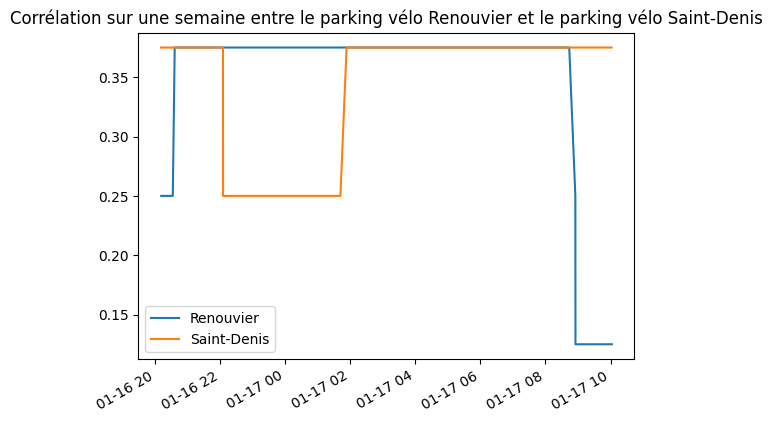

In [18]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData
%store -r bicycleData 

parkingbicycle1="Renouvier"
parkingbicycle2="Saint-Denis"

fig, ax = plt.subplots()
plt.title("Corrélation sur une semaine entre le parking vélo "+parkingbicycle1+" et le parking vélo "+ parkingbicycle2)
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle1:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle2:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
plt.legend()
plt.show()

### Corrélation entre 1 parking vélo et 1 parking voiture prohes sur le temps (manque de corrélations textuelles voir paragraphe des problèmes rencontrés)

In [22]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
# On charge les datasets
%store -r carData
%store -r bicycleData 

parkingcar=input("Entrez le nom du parking voiture:") #on laisse entrer le parking voiture à afficher grapiquement plutôt que de le définir en amont.
parkingbicycle=input("Entrez le nom du parking vélo:") #pareil mais pour le parking vélo à afficher sur le même graphique que celui du parking voiture
fig, ax = plt.subplots()
plt.title("Corrélation sur une semaine entre le parking voiture "+parkingcar+" et le parking vélo "+parkingbicycle)
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas

for name, datapoints in parkingsByName(carData).items():
    if name == parkingcar:
        mean_car_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_car_array, label=name)
for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
plt.legend()
plt.show()

## Générateur de graphiques
Vous pouvez essayer vous aussi de trouver des corrélations grâce à ce code qui génère sur un même graphique le taux d'occupation d'un parking voiture et d'un parking vélo de votre choix !

In [ ]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from Utils import parkingsByName
%store -r carData
%store -r bicycleData 

parkingcar=input("Entrez le nom d'un parking voiture:")
parkingbicycle=input("Entrez le nom d'un parking vélo:")
fig, ax = plt.subplots()
plt.title("Corrélation sur une semaine entre le parking voiture "+parkingcar+" et le parking vélo "+parkingbicycle)
fig.autofmt_xdate() # 

for name, datapoints in parkingsByName(carData).items():
    if name == parkingcar:
        mean_car_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_car_array, label=name)
for name, datapoints in parkingsByName(bicycleData).items():
    if name == parkingbicycle:
        mean_bicycle_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
        plotContainer = plt.plot([datetime.fromtimestamp(datapoint.getDate()) for datapoint in datapoints], mean_bicycle_array, label=name)
plt.legend()
plt.show()

## Problèmes rencontrés:

Il est important de noter que nous n'avons pas pu calculer la co-variance qui aurait permis de trouver une corrélation chiffrée entre un parking voiture et vélo car les données ne sont pas données à des instants identiques. En effet, le taux d'échantillonage du parking voiture n'est pas le même que celui des parkings vélos...
De plus, comme vous pouvez le voir, certains graphiques n'ont pas pu être réalisés à cause de la nécéssité de selectionner une date en particulier. En effet, le manque de temps nous a empêché de configurer nos dates sous forme selectionnable. 